# Matrix completion Framework

Utilities fonctions availables at `utils.py`

In [3]:
from utils import create_ns, completion_matrix, completion_matrix_ot_breg, bins_completion, plot_matrix

## Create ns

If you have the ``comma_location`` and the series tokenized in the string format ``full_series`` you can use ``create_ns`` to create a list containing the 3 digits tokens.

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"

In [4]:
ns = create_ns(full_series,comma_locations)

NameError: name 'full_series' is not defined

## Filling the matrix

You can extract the refined bins of the PDF_list with ``bins_completion``. With ``completion_matrix_ot_breg`` you create the sparse matrix that you fill with the bins, and you use Optimal Transport to fill the empty rows. It returns the transition matrix 1000x1000 and a hashmap containing the position of the seen state. You can use ``plot_matrix`` to visualise which rows of the matrix was seen (so, before filling the sparsity with OT). btw, you can use``completion_matrix`` to do the same thing but you do not use OT to fill the empty rows : you go to the neareast seen state with probability 1.

In [ ]:
bins_ = bins_completion(PDF_list)
ps, hashmap = completion_matrix_ot_breg(bins_,ns,discrete_BT_loss)

In [ ]:
ps2, hashmap2 = completion_matrix(bins_,ns,discrete_BT_loss)

In [ ]:
plot_matrix(hashmap)

## Visualizing the matrix

### With OT

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(ps)

### Without OT

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(ps2)

# Example on a time serie processed by the LLM

Now, I will load an example to show you

## Load stuffs...

In [9]:
import sys
import os
from pathlib import Path

import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
sys.path.append("../models")
processed_series_path = Path(parent_dir) / 'processed_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle

print(sys.path)
from ICL import MultiResolutionPDF

['/home/ozekri/miniforge3/envs/LLMICL/lib/python39.zip', '/home/ozekri/miniforge3/envs/LLMICL/lib/python3.9', '/home/ozekri/miniforge3/envs/LLMICL/lib/python3.9/lib-dynload', '', '/home/ozekri/miniforge3/envs/LLMICL/lib/python3.9/site-packages', '/home/ozekri/llmICL', '../models', '/home/ozekri/llmICL', '../models']


In [10]:
from utils import create_ns, completion_matrix, completion_matrix_ot_breg, bins_completion, plot_matrix

In [11]:
all_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
for index, file in enumerate(all_files):
    print(f"[{index}]: {file.name}")

[0]: Fokker_Planck_linkedSDE_27.pkl
[1]: Fokker_Planck_linkedSDE_28.pkl
[2]: Fokker_Planck_linkedSDE_30.pkl
[3]: Fokker_Planck_linkedSDE_31.pkl
[4]: Fokker_Planck_linkedSDE_sketch.pkl
[5]: Fokker_Planck_linkedSDE_sketch_10.pkl
[6]: Fokker_Planck_linkedSDE_sketch_11.pkl
[7]: Fokker_Planck_linkedSDE_sketch_5.pkl
[8]: Fokker_Planck_linkedSDE_sketch_8.pkl
[9]: ambroise_diff_0.pkl
[10]: ambroise_diff_1.pkl
[11]: ambroise_diff_2.pkl
[12]: ambroise_sum_0.pkl
[13]: ambroise_theta0_0.pkl
[14]: ambroise_theta1_0.pkl
[15]: brownian_motion_0.pkl
[16]: brownian_motion_1.pkl
[17]: brownian_motion_10.pkl
[18]: brownian_motion_11.pkl
[19]: brownian_motion_12.pkl
[20]: brownian_motion_13.pkl
[21]: brownian_motion_14.pkl
[22]: brownian_motion_15.pkl
[23]: brownian_motion_16.pkl
[24]: brownian_motion_17.pkl
[25]: brownian_motion_18.pkl
[26]: brownian_motion_19.pkl
[27]: brownian_motion_2.pkl
[28]: brownian_motion_3.pkl
[29]: brownian_motion_4.pkl
[30]: brownian_motion_5.pkl
[31]: brownian_motion_6.pkl
[3

In [12]:
alpha = 1

file = all_files[173]
# file = all_files[21]
# file = all_files[4]
processed_dict = pickle.load(file.open('rb'))
full_series = processed_dict['full_series']
rescaled_true_mean_arr = processed_dict['rescaled_true_mean_arr']
rescaled_true_sigma_arr = processed_dict['rescaled_true_sigma_arr']
llama_size = processed_dict['llama_size']
mode = processed_dict['mode']
refine_depth = processed_dict['refine_depth']
random_seed = processed_dict['random_seed']
PDF_list = processed_dict['PDF_list']
time_series = processed_dict['time_series']
prec = processed_dict['prec']
print(f"seed: {processed_dict['random_seed']}")
print(f"mode: {mode}")
print(f"refine_depth: {refine_depth}")
print(f"prec: {prec}")
print(f"name: {file.stem}")

seed: 0
mode: neighbor
refine_depth: 1
prec: 3
name: non_convex_0.4_w1_0


In [13]:
### tune temperature 

for PDF in PDF_list:
    if alpha != 1:
        PDF.rescale_temperature(alpha)

In [14]:
### Calculate true discretized distribution: PDF_list_true
### Compute discretized BT and KL loss

PDF_true_list = copy.deepcopy(PDF_list)
discrete_BT_loss = []
discrete_KL_loss = []
discrete_WT_loss = []
for PDF, PDF_true, true_mean, true_sigma in zip(PDF_list, PDF_true_list, rescaled_true_mean_arr, rescaled_true_sigma_arr):
    def cdf(x):
        return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
    
    PDF_true.discretize(cdf, mode = "cdf")
    PDF_true.compute_stats()
    discrete_BT_loss += [PDF_true.BT_dist(PDF)]    
    discrete_KL_loss += [PDF_true.KL_div(PDF)]
    discrete_WT_loss += [PDF_true.WT_dist(PDF)]


discrete_BT_loss = np.array(discrete_BT_loss)
discrete_KL_loss = np.array(discrete_KL_loss)
discrete_WT_loss = np.array(discrete_WT_loss)

### Extract statistics from MultiResolutionPDF

mean_arr = []
mode_arr = []
sigma_arr = []
moment_3_arr = []
moment_4_arr = []

num_commas = full_series.count(',')
for comma_idx in range(num_commas):
    PDF_list[comma_idx].compute_stats()
    mean, mode, sigma = PDF_list[comma_idx].mean, PDF_list[comma_idx].mode, PDF_list[comma_idx].sigma 
    moment_3 = PDF_list[comma_idx].compute_moment(3)
    moment_4 = PDF_list[comma_idx].compute_moment(4)
    
    mean_arr.append(mean)
    mode_arr.append(mode)
    sigma_arr.append(sigma)
    moment_3_arr.append(moment_3)
    moment_4_arr.append(moment_4)

# Convert lists to numpy arrays
mean_arr = np.array(mean_arr)
mode_arr = np.array(mode_arr)
sigma_arr = np.array(sigma_arr)
moment_3_arr = np.array(moment_3_arr)
moment_4_arr = np.array(moment_4_arr)

error_mean = np.abs(rescaled_true_mean_arr - mean_arr)
error_mode = np.abs(rescaled_true_mean_arr - mode_arr)

/tmp/ipykernel_2319181/499913996.py:10: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/tmp/ipykernel_2319181/499913996.py:10: RuntimeWarning: invalid value encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))


## How it works in practice

### Create ns

In [16]:
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])
ns = create_ns(full_series,comma_locations)

# T

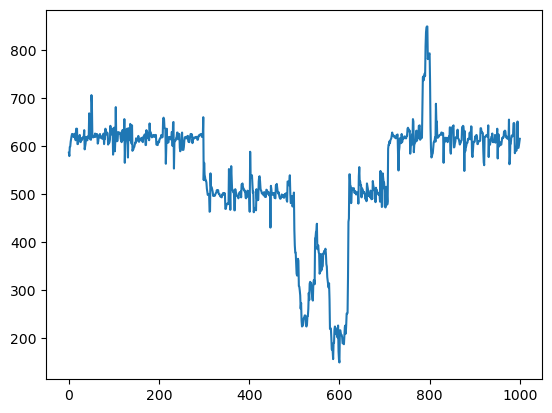

In [20]:
plt.plot(ns)

### Compute the matrices

In [17]:
bins_ = bins_completion(PDF_list)
ps, hashmap = completion_matrix_ot_breg(bins_,ns,discrete_BT_loss)

/home/ozekri/llmICL/figures_analysis/utils.py:32: RuntimeWarning: invalid value encountered in divide
  normalized_probabilities = np.where(non_zero_sums_mask, np.true_divide(prob, row_sums), prob)
100%|█████████████████████████████████████████████████████████████████████████████████| 275/275 [02:13<00:00,  2.06it/s]


In [18]:
ps2, hashmap2 = completion_matrix(bins_,ns,discrete_BT_loss)

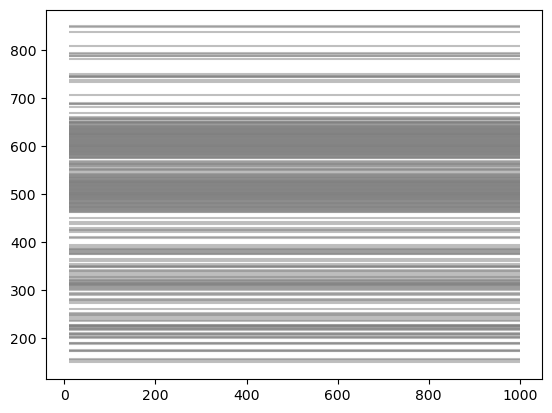

In [19]:
plot_matrix(hashmap)

### Visualize the matrices

#### With OT

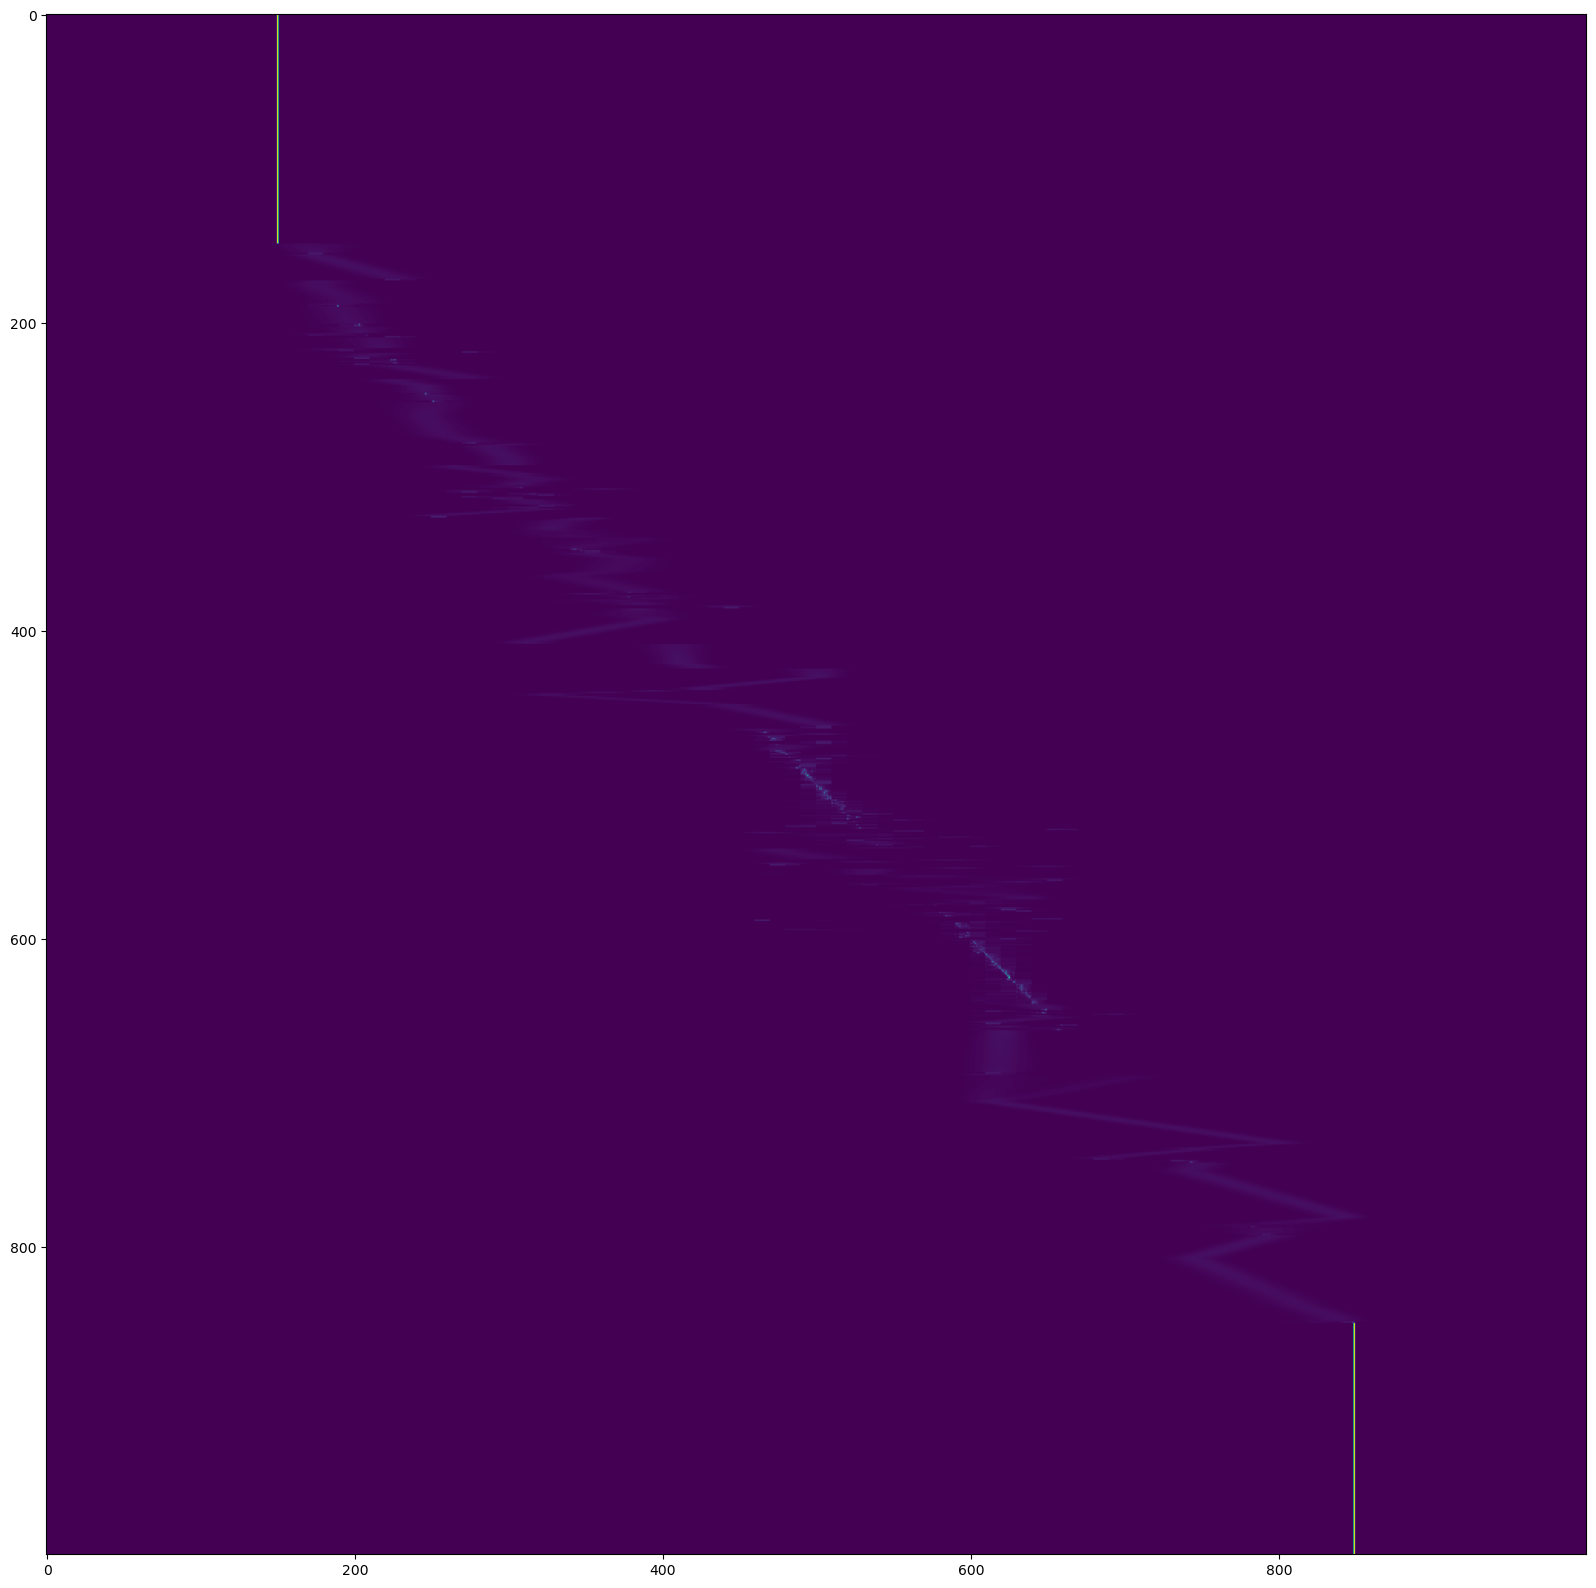

In [21]:
plt.figure(figsize=(20,20))
plt.imshow(ps)

#### Without OT

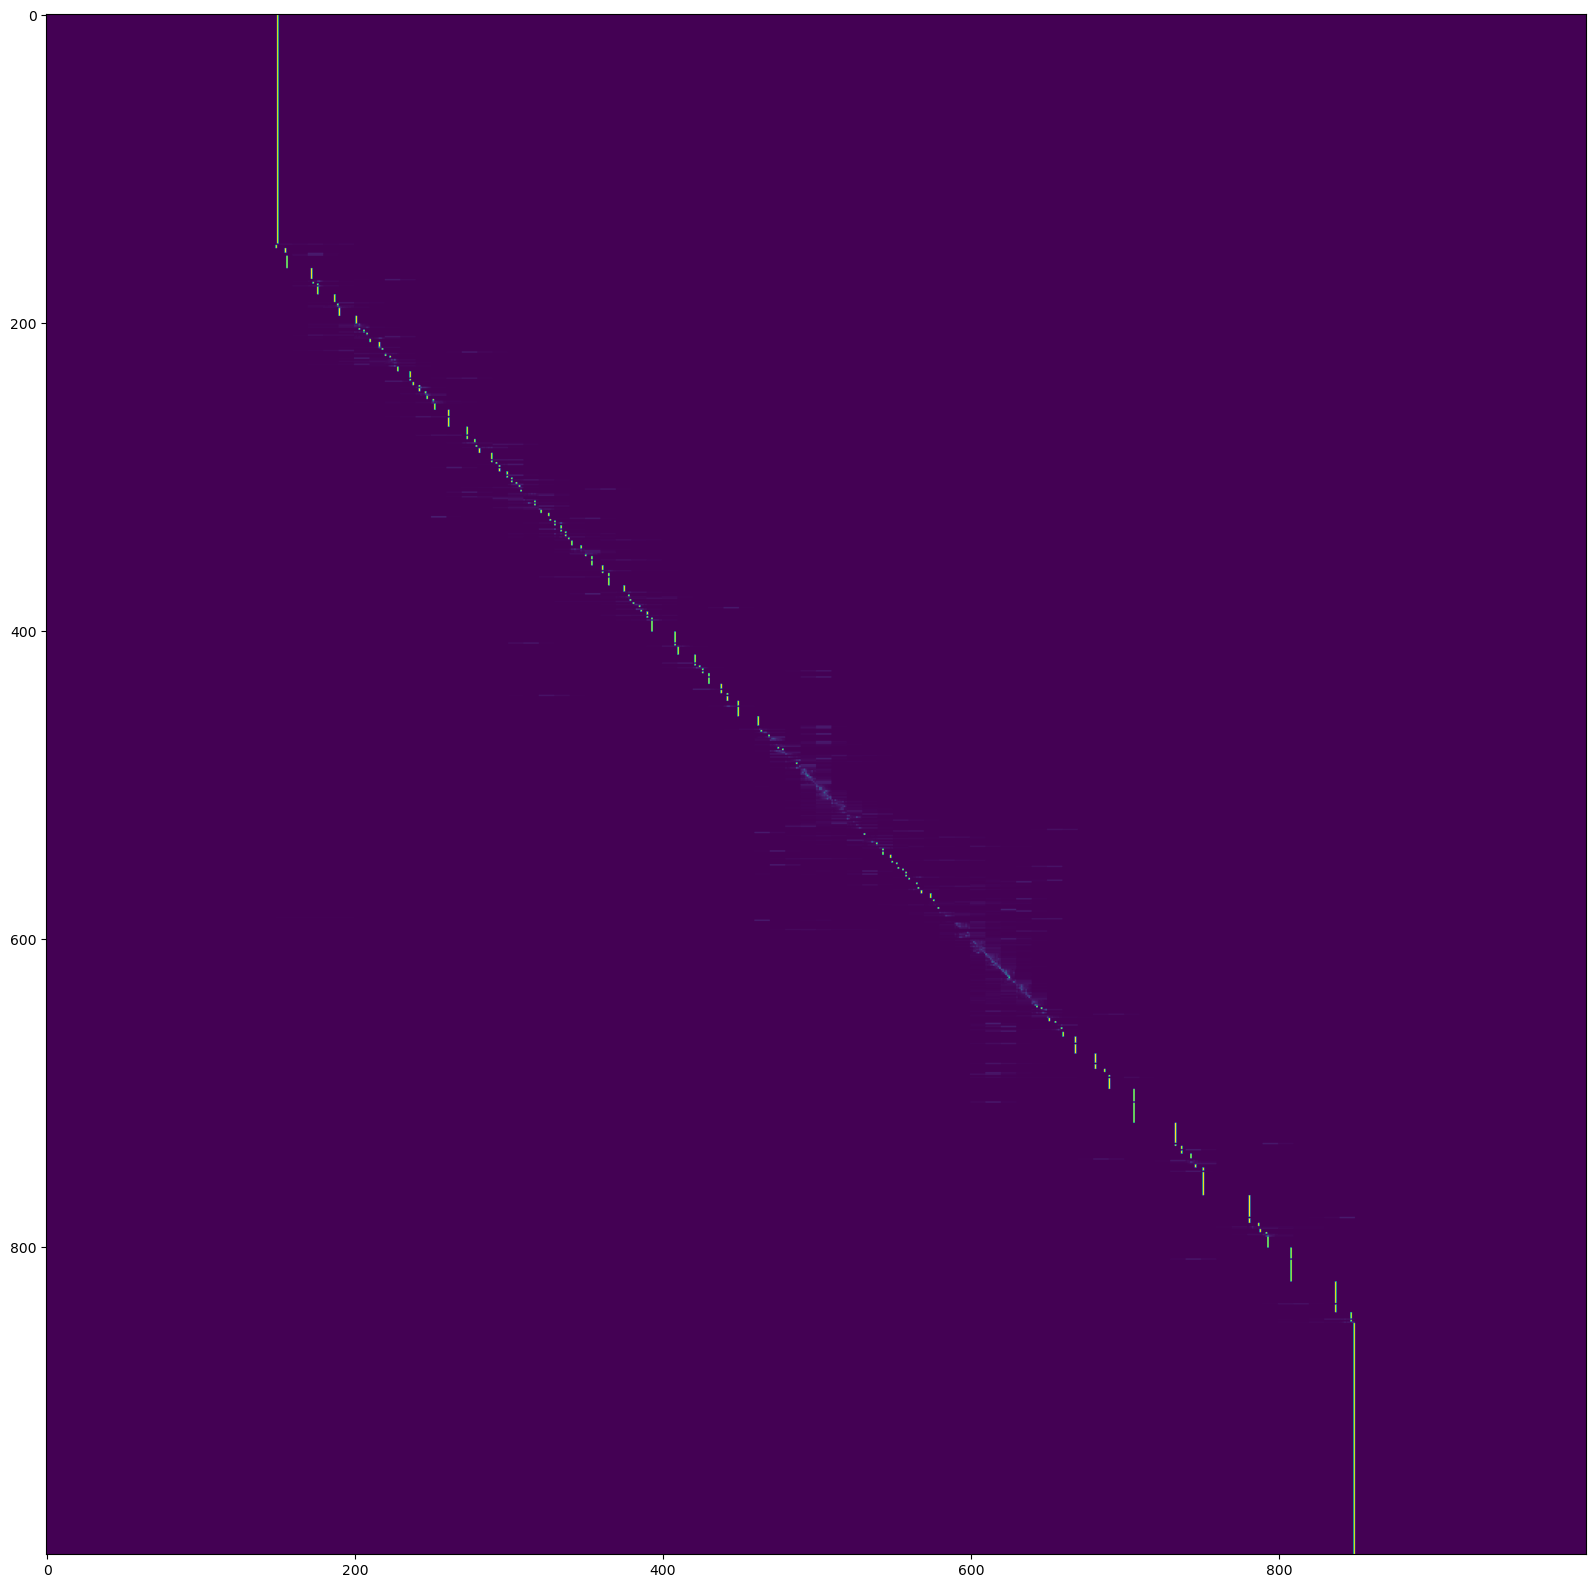

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(ps2)